# Цель проекта:

В своем проекте я буду анализировать самостоятельно подготовленный датасет (выгрузка из открытых источников, информационный ресурс СПАРК интерфакс). Датасет представляет собой выгрузку с показателями деятельности, в частности годового объема выплаченной заработной платы по 13697 Российским компаниям.
Целью данного проекта - классификация компаний с годовой оплатой труда более среднего значения по стране. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#data = pd.read_excel('Companies.xlsx') при работе с локальной версией

In [2]:
from google.colab import drive #для google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/Dementev-Ilia/payroll_analysis.git/

fatal: destination path 'payroll_analysis' already exists and is not an empty directory.


In [0]:
data = pd.read_excel('/content/payroll_analysis/Companies.xlsx') #загружаем данные

In [0]:
df = data.copy() #сохраняю копию датасета (первоначальные данные потребуются для построения предсказаний)

In [6]:
df.head(5)

,"Возраст компании, лет",Регион регистрации,Вид деятельности/отрасль,Организационно-правовая форма,"2018, Среднесписочная численность работников","Уставный капитал, RUB","2018, Доходы, RUB","2018, Расходы, RUB","2018, Налоги, RUB","2018, Страховые взносы в ПФР, RUB","2018, Уставный капитал , RUB","2018, Выручка, RUB","2018, Оплата труда, RUB"
0,13.0,Псковская область,Агломерация торфа,Общества с ограниченной ответственностью,97.0,10000.0,494224000.0,462466000.0,43388045.0,9005246.0,10000.0,357464000,NaN
1,2.5,Мурманская область,Аренда грузового автомобильного транспорта с в...,Общества с ограниченной ответственностью,13.0,100000.0,125612000.0,74897000.0,5800614.0,1965044.0,NaN,122455000,NaN
2,14.0,Санкт-Петербург,"Аренда и лизинг прочих видов транспорта, обору...",Общества с ограниченной ответственностью,76.0,10000.0,364692000.0,361322000.0,38307339.0,10081487.0,10000.0,345446000,NaN
3,6.0,Санкт-Петербург,Аренда и лизинг прочих машин и оборудования на...,Общества с ограниченной ответственностью,16.0,30000.0,215452000.0,214183000.0,3566684.0,1494834.0,30000.0,206558000,NaN
4,11.0,Санкт-Петербург,"Аренда и лизинг прочих машин и оборудования, н...",Общества с ограниченной ответственностью,15.0,10000.0,147560000.0,134263000.0,21783067.0,1949765.0,NaN,131353000,NaN


# Обработка данных


In [7]:
df.count() #выводим количество заполненных значений в колонках

Возраст компании, лет                           13697
Регион регистрации                              13697
Вид деятельности/отрасль                        13697
Организационно-правовая форма                   13697
2018, Среднесписочная численность работников    13236
Уставный капитал, RUB                           13647
2018, Доходы, RUB                               13231
2018, Расходы, RUB                              13231
2018, Налоги, RUB                               13332
2018, Страховые взносы в ПФР, RUB               13293
2018, Уставный капитал , RUB                    10668
2018, Выручка, RUB                              13697
2018, Оплата труда, RUB                          5935
dtype: int64

на данном этапе столкнулся с проблемой что данные по оплате труда заполнены только по 5477 компаниям, т. е. фактически придется оперировать значительно меньшим объемом данных

In [0]:
df.dropna(inplace=True) #для более корректного анализа я принял решение удалить пропущенные значения

In [9]:
df.describe()

,"Возраст компании, лет","2018, Среднесписочная численность работников","Уставный капитал, RUB","2018, Доходы, RUB","2018, Расходы, RUB","2018, Налоги, RUB","2018, Страховые взносы в ПФР, RUB","2018, Уставный капитал , RUB","2018, Выручка, RUB","2018, Оплата труда, RUB"
count,5477.000000,5477.000000,5.477000e+03,5.477000e+03,5.477000e+03,5.477000e+03,5.477000e+03,5.477000e+03,5.477000e+03,5.477000e+03
mean,14.205404,172.150630,3.388557e+07,2.371473e+09,2.257950e+09,8.042387e+07,2.150671e+07,3.092703e+07,1.230981e+09,1.298515e+08
std,7.312745,453.469377,3.127226e+08,7.694659e+10,7.355838e+10,2.238858e+08,6.717617e+07,2.626588e+08,2.698839e+09,4.244422e+08
min,2.000000,0.000000,1.460000e+02,2.547640e+05,1.974180e+05,5.037700e+04,1.900900e+04,1.000000e+03,1.000170e+08,1.600000e+04
25%,8.000000,23.000000,1.000000e+04,2.464310e+08,2.366080e+08,1.135188e+07,2.332103e+06,1.000000e+04,2.310400e+08,1.117800e+07
50%,13.000000,66.000000,5.000000e+04,5.339910e+08,5.140980e+08,2.983043e+07,7.181132e+06,5.000000e+04,4.971690e+08,3.830500e+07
75%,19.500000,169.000000,1.002000e+06,1.291113e+09,1.229677e+09,7.564366e+07,1.939507e+07,1.000000e+06,1.208512e+09,1.121720e+08
max,66.500000,15334.000000,1.229880e+10,5.691345e+12,5.441270e+12,8.154024e+09,2.726260e+09,8.611247e+09,7.352372e+10,1.824263e+10


In [0]:
#удаляем ненужные столбцы
df = df.drop(['Уставный капитал, RUB', 'Организационно-правовая форма', '2018, Уставный капитал , RUB'], axis=1)

In [0]:
df['Оплата труда в месяц, RUB'] = df['2018, Оплата труда, RUB'] // 12 #добавил колонку с ежемесячным фондом оплаты труда

In [0]:
#так как я хочу предсказывать ежемесячный фонд оплаты труда, данные за год нам больше не нужны
df = df.drop(['2018, Оплата труда, RUB'], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 10 to 13694
Data columns (total 10 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Возраст компании, лет                         5477 non-null   float64
 1   Регион регистрации                            5477 non-null   object 
 2   Вид деятельности/отрасль                      5477 non-null   object 
 3   2018, Среднесписочная численность работников  5477 non-null   float64
 4   2018, Доходы, RUB                             5477 non-null   float64
 5   2018, Расходы, RUB                            5477 non-null   float64
 6   2018, Налоги, RUB                             5477 non-null   float64
 7   2018, Страховые взносы в ПФР, RUB             5477 non-null   float64
 8   2018, Выручка, RUB                            5477 non-null   int64  
 9   Оплата труда в месяц, RUB                     5477 non-null  

## Преобразование данных с помощью LabelEncoder



In [14]:
# Подключаем класс для предобработки данных
from sklearn import preprocessing

# Напишем функцию, которая принимает на вход DataFrame, кодирует числовыми значениями категориальные признаки
# и возвращает обновленный DataFrame и сами кодировщики.
def number_encode_features(init_df):
    result = init_df.copy() # копируем нашу исходную таблицу
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object: # np.object -- строковый тип / если тип столбца - строка, то нужно его закодировать
            encoders[column] = preprocessing.LabelEncoder() # для колонки column создаем кодировщик
            result[column] = encoders[column].fit_transform(result[column]) # применяем кодировщик к столбцу и перезаписываем столбец
    return result, encoders

encoded_data, encoders = number_encode_features(df) # Теперь encoded data содержит закодированные кат. признаки 
encoded_data.head() 

,"Возраст компании, лет",Регион регистрации,Вид деятельности/отрасль,"2018, Среднесписочная численность работников","2018, Доходы, RUB","2018, Расходы, RUB","2018, Налоги, RUB","2018, Страховые взносы в ПФР, RUB","2018, Выручка, RUB","Оплата труда в месяц, RUB"
10,25.5,19,8,184.0,2.645170e+08,2.918430e+08,48169258.0,13136286.0,209443000,6964333.0
11,24.5,39,8,33.0,2.188230e+08,1.827160e+08,17084877.0,2816083.0,193743000,1530833.0
12,7.0,25,13,270.0,6.496770e+08,6.138320e+08,33187588.0,26533582.0,502813000,8687750.0
13,30.5,53,16,273.0,1.920450e+08,1.910170e+08,60732585.0,23600332.0,189951000,11780583.0
22,6.0,53,17,251.0,3.006068e+09,2.956986e+09,110927474.0,14235971.0,2978128000,5801500.0


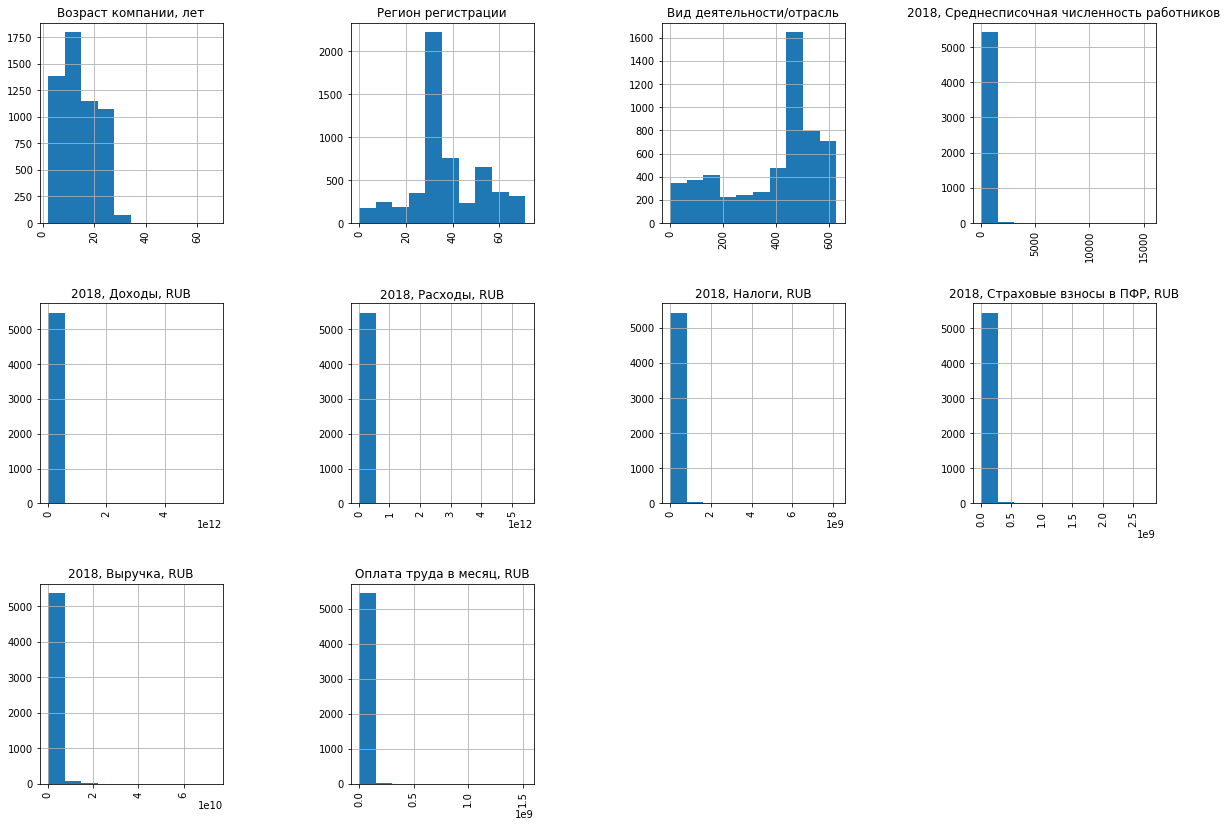

In [15]:
#
fig = plt.figure(figsize=(20,14))
cols = 4

rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.4, wspace=0.7)

## Нахожу линейные корреляции

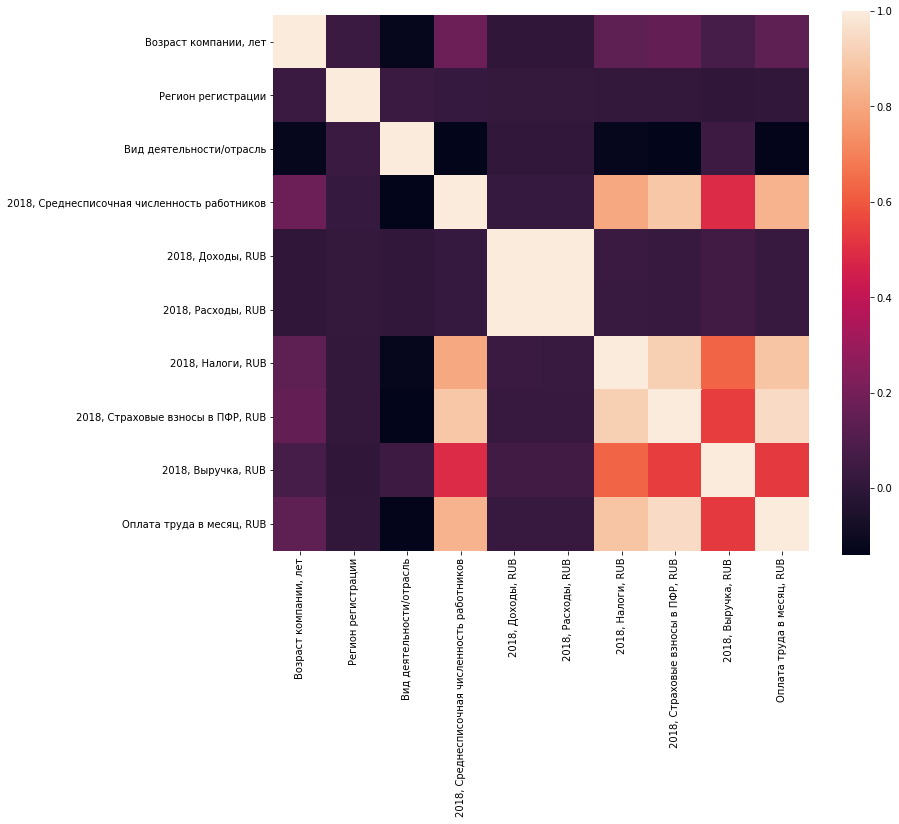

In [16]:
#выведем график корреляции
plt.subplots(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), square = True)
plt.show()

In [0]:
#на графиках мы видим логичную зависимость размера выплат в пенсионый фонд и суммы уплаченных налогов от размера оплаты труда

In [0]:
#удалим данные по сумманым годовым расходам компаний
encoded_data = encoded_data.drop(['2018, Расходы, RUB'], axis=1)

#остальные данные нам потребуются для классификации

## Оптимизирую данные (убираю выбросы)

In [0]:
#Хотел постройть график для визуализации количества данных по городам (график получился не очень удачным из-за количества анализируемых признаков)
#df["Регион регистрации"].value_counts().plot.pie(explode=[0.1] * 72,autopct='%1.1f%%',shadow=True,figsize=(20,20))
#plt.show()

In [20]:
# отдельно проанализируем столбец регион регистрации
print(df["Регион регистрации"].value_counts())
#видим что в нашем датасете половина данных относиться к Москве и Московской области

Москва                             2056
Московская область                  490
Санкт-Петербург                     300
Свердловская область                220
Краснодарский край                  154
                                   ... 
Кабардино-Балкарская Республика       4
Магаданская область                   3
Забайкальский край                    3
Тыва (Республика)                     2
Республика Татарстан                  1
Name: Регион регистрации, Length: 72, dtype: int64


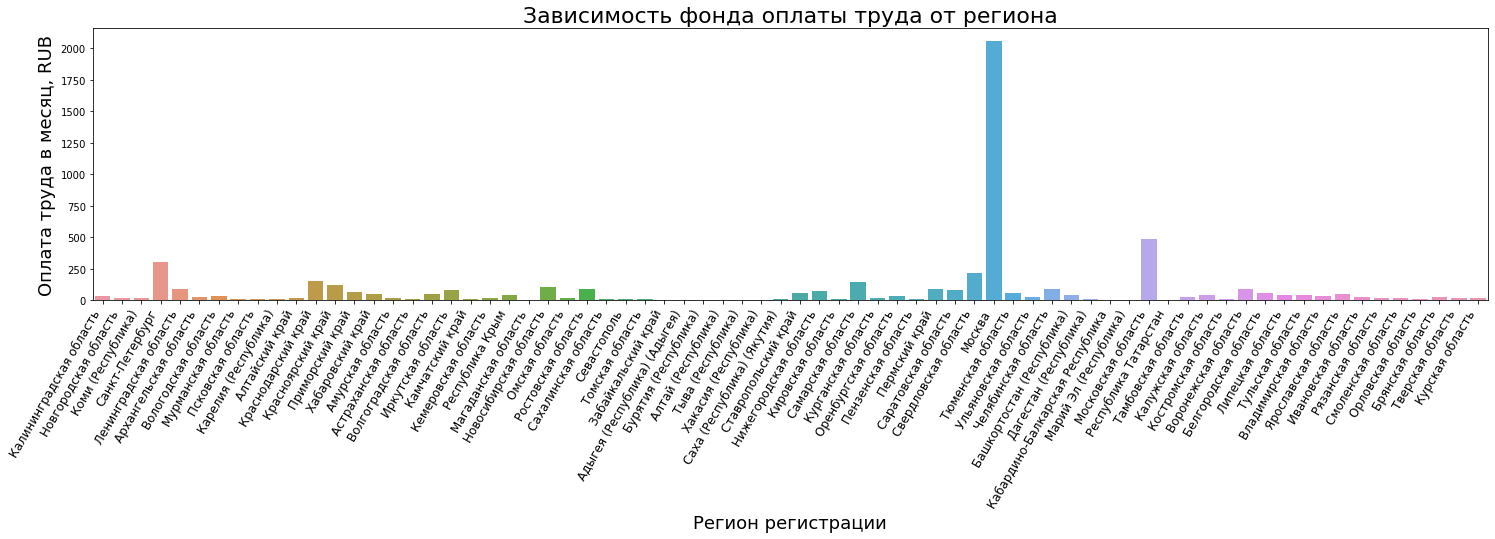

In [21]:
# выведем график соотношения оплаты труда от региона
fig, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Регион регистрации", data=df)
plt.title("Зависимость фонда оплаты труда от региона", fontsize=22)
plt.xlabel('Регион регистрации', fontsize=18)
plt.ylabel('Оплата труда в месяц, RUB', fontsize=18)
plt.xticks(rotation=60, fontsize=12, ha='right')
plt.show()

In [0]:
#Из графика видно что размер заработной платы в Москве значительно отличается от регионов
#на мой взгляд логично разбить датасет на 2 части для того чтобы отдельно анализировать данные по Москве и по регионам
#создадим копию датасета для отдельного анализа по городу Москва
df_Moscov = df.copy()

In [0]:
df = df.loc[~df['Регион регистрации'].isin(["Москва", 'Московская область'])] #сделаем отдельный набор данных за исключением Москвы и Московской области

In [0]:
df_Moscov = df_Moscov.loc[df_Moscov['Регион регистрации'].isin(["Москва", 'Московская область'])] #Москва и Московская область

In [0]:
encoded_data, encoders = number_encode_features(df)

In [27]:
encoded_data['Регион регистрации'].shape

(2931,)

In [29]:
#найдем средний размер оплаты труда в регионах
np.mean(encoded_data['Оплата труда в месяц, RUB'])#это суммарный объем заработной платы выплаченный компанией за месяц

9876374.364721937

In [30]:
#найдем среднюю зарплату на человека в месяц в регионах
salary = np.mean(encoded_data['Оплата труда в месяц, RUB']) // np.mean(encoded_data['2018, Среднесписочная численность работников'])
print('Средняя заработная плата в регионах', salary, 'рублей')

Средняя заработная плата в регионах 48247.0 рублей


In [31]:
#найдем средний размер оплаты труда в Москве и Московской обл
np.mean(df_Moscov['Оплата труда в месяц, RUB'])#это суммарный объем заработной платы выплаченный компанийей за месяц

11908371.298507463

In [32]:
#найдем среднюю зарплату на человека в месяц
salary_Moscov = np.mean(df_Moscov['Оплата труда в месяц, RUB']) // np.mean(df_Moscov['2018, Среднесписочная численность работников'])
print('Средняя заработная плата в Москве', salary_Moscov, 'рублей')

Средняя заработная плата в Москве 88422.0 рублей


Будем выявлять компании с фондом оплаты труда выше среднего

In [0]:
encoded_data['Оплата труда в месяц, RUB'] = encoded_data['Оплата труда в месяц, RUB'].apply((lambda x: x <= np.mean(encoded_data['Оплата труда в месяц, RUB']))) # Будем предсказывать 1(True), если ФОТ больше среднего по стране, иначе 0(False)

In [0]:
#импортируем библиотеки для визуализаации
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  
import warnings
warnings.filterwarnings('ignore')

True     2259
False     672
Name: Оплата труда в месяц, RUB, dtype: int64
Процент данных ниже среднего" 0.23


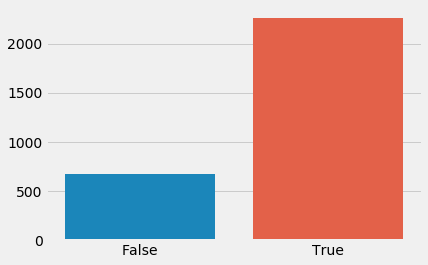

In [0]:
print(encoded_data['Оплата труда в месяц, RUB'].value_counts()) #проверяем сбалансированны ли классы

sns.barplot(encoded_data['Оплата труда в месяц, RUB'].value_counts().index, encoded_data['Оплата труда в месяц, RUB'].value_counts().values)
print('Процент данных ниже среднего"', round(encoded_data['Оплата труда в месяц, RUB'][encoded_data['Оплата труда в месяц, RUB'] == False].shape[0]/len(encoded_data), 2))
#классы плохо сбалансированы

## Инициализирую целевую переменную

In [0]:
#Инициалзируем целевую переменную
y = encoded_data['Оплата труда в месяц, RUB'].map({True: 1, False: 0}).values
encoded_data.drop(['Оплата труда в месяц, RUB'], axis = 1, inplace=True)

In [0]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
#Преобразуем выборку массив 
X = np.array(encoded_data)
X

array([[2.5500000e+01, 1.9000000e+01, 6.0000000e+00, ..., 4.8169258e+07,
        1.3136286e+07, 2.0944300e+08],
       [2.4500000e+01, 3.7000000e+01, 6.0000000e+00, ..., 1.7084877e+07,
        2.8160830e+06, 1.9374300e+08],
       [7.0000000e+00, 2.5000000e+01, 1.1000000e+01, ..., 3.3187588e+07,
        2.6533582e+07, 5.0281300e+08],
       ...,
       [1.4500000e+01, 1.6000000e+01, 4.7800000e+02, ..., 5.4040920e+06,
        9.3321200e+05, 1.1682300e+08],
       [1.3000000e+01, 5.9000000e+01, 4.7900000e+02, ..., 3.2882772e+07,
        1.4716359e+07, 6.3851700e+08],
       [7.0000000e+00, 1.3000000e+01, 4.7900000e+02, ..., 2.7767990e+06,
        5.6343700e+05, 3.1986500e+08]])

In [0]:
#Нормализуем данные
from sklearn import preprocessing
X_scaled= preprocessing.scale(X)
X_scaled

array([[ 1.35379732, -1.11524537, -2.20945432, ..., -0.13824198,
        -0.13430974, -0.43612465],
       [ 1.22040863, -0.12473806, -2.20945432, ..., -0.29399304,
        -0.29720487, -0.44353861],
       [-1.11389338, -0.78507627, -2.1712648 , ..., -0.21330897,
         0.07715455, -0.29758751],
       ...,
       [-0.11347823, -1.28032992,  1.39563589, ..., -0.35252066,
        -0.3269243 , -0.47986229],
       [-0.31356126,  1.08588199,  1.40327379, ..., -0.21483628,
        -0.1093697 , -0.23350445],
       [-1.11389338, -1.44541447,  1.40327379, ..., -0.36568494,
        -0.33276087, -0.38398044]])

In [0]:
print(X.shape, y.shape)

(2931, 9) (2931,)


# Алгоритмы

In [0]:
#Инициализируем алгоритмы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.model_selection import GridSearchCV

## Классифицируем данные с помощью KNN

In [0]:
knn = KNeighborsClassifier()

# Зададим сетку - среди каких значений выбирать наилучший параметр.
knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')} # перебираем по параметру <<n_neighbors>>, по сетке заданной np.linspace(1, 100, 10)

# Создаем объект кросс-валидации
gs = GridSearchCV(knn, knn_grid, cv=5)

# Обучаем его
gs.fit(X_scaled, y)
gs.best_params_, gs.best_score_ #получаем наилудшие параметры

({'n_neighbors': 12}, 0.9109534801239599)

In [0]:
# Функция отрисовки графиков
def grid_plot(x, y, x_label, title, y_label='cross_val'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

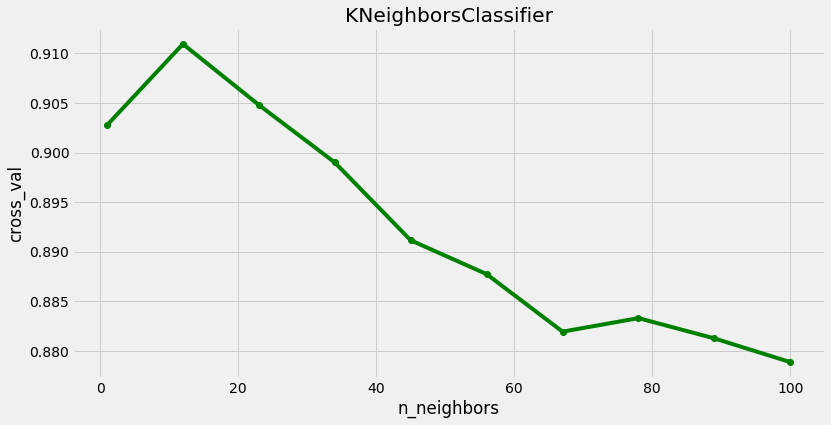

In [0]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

## Классифицируем данные с помощью Random Forest


In [0]:
# перебираем глубину
# перебираем мин кол-во для разделения
# максимально кол-во признаков для более случайной выборки
param_grid = {'max_depth': [i for i in range(2, 15)],
              'min_samples_split': [i for i in range(2, 10)],
              'max_features': [2, len(X_scaled[0])-1]
              }


# инициализируем случайный лес с перебором по кросс-вал на выбранных выше праметрах
rf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
rf.fit(X_scaled, y)

# best_params_ содержит в себе лучшие подобранные параметры, best_score_ лучшее качество
print()
rf.best_params_, rf.best_score_

({'max_depth': 7, 'max_features': 2, 'min_samples_split': 7},
 0.955650004942119)

In [0]:
def plot_feature_importances(model, columns):
    # выбираем кол-во признаков для отображения
    nr_f = 10
    # берем данные для графика
    # берем алгоритм с лучшими параметрами
    # по х мы берем важность признаков исходя из критерия Джини, сортируем их вместе с названиями колонок по возрастанию
    imp = pd.Series(data = model.best_estimator_.feature_importances_, 
                    index=columns).sort_values(ascending=False)
    # построили фигуру
    plt.figure(figsize=(7,5))
    # отобразили название
    plt.title("Важность признаков | Feature importance")
    # построили 10 самых важных признаков
    ax = sns.barplot(y=imp.index[:nr_f], x=imp.values[:nr_f], orient='h')

### Отображаем самые важные признаки

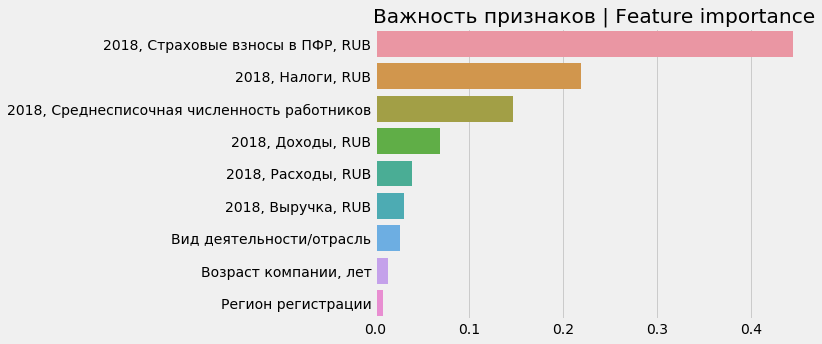

In [0]:
# вызвали функцию отображения самых важных признаков
plot_feature_importances(rf, encoded_data.columns)

Основные признаки, влияющие на целевую переменную:  налоги, среднесписочная численность, страховые взносы

## Нейросеть

### One hot кодирование

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
cat_columns = list(df.select_dtypes(include='object').columns)

df[cat_columns].head()

,Регион регистрации,Вид деятельности/отрасль
10,Калининградская область,Аренда и управление собственным или арендованн...
11,Новгородская область,Аренда и управление собственным или арендованн...
12,Коми (Республика),Выращивание овощей
13,Санкт-Петербург,"Дезинфекция, дезинсекция, дератизация зданий, ..."
22,Санкт-Петербург,Деятельность автомобильного грузового транспорта


In [0]:
# кодируем категориальные признаки
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(df[cat_columns])

X_one_hot = enc.transform(df[cat_columns]).toarray()

In [0]:
X_one_hot

array([[2.55000e+01, 1.84000e+02, 2.64517e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.45000e+01, 3.30000e+01, 2.18823e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [7.00000e+00, 2.70000e+02, 6.49677e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [1.45000e+01, 4.00000e+00, 1.18709e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.30000e+01, 1.81000e+02, 6.49575e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [7.00000e+00, 2.00000e+01, 3.22366e+08, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [0]:
X_one_hot = np.concatenate((df.drop(columns=cat_columns).values, X_one_hot), axis=1)

In [0]:
X_one_hot.shape

(2931, 563)

###Обучаю нейросеть

In [0]:
# импортируем последовательную модель
from keras.models import Sequential
# импортируем слой полносвязной сети
from keras.layers import Dense

In [0]:
model = Sequential()
model.add(Dense(128, input_dim=563, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.35)

In [0]:
# обучим модель с батчем в 64, за 30 эпохах, проверяем по тесту
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=30,
                    batch_size=64)
# финальная проверка
results = model.evaluate(X_test, y_test)
print("Тестовый loss и accuracy", results)

Train on 1905 samples, validate on 1026 samples
Epoch 1/30
1905/1905 [==============================] - 2s 986us/step - loss: 0.5573 - acc: 0.7643 - val_loss: 0.5236 - val_acc: 0.7827
Epoch 2/30
1905/1905 [==============================] - 0s 90us/step - loss: 0.5470 - acc: 0.7643 - val_loss: 0.5252 - val_acc: 0.7827
Epoch 3/30
1905/1905 [==============================] - 0s 97us/step - loss: 0.5463 - acc: 0.7643 - val_loss: 0.5248 - val_acc: 0.7827
Epoch 4/30
1905/1905 [==============================] - 0s 89us/step - loss: 0.5464 - acc: 0.7643 - val_loss: 0.5250 - val_acc: 0.7827
Epoch 5/30
1905/1905 [==============================] - 0s 94us/step - loss: 0.5471 - acc: 0.7643 - val_loss: 0.5249 - val_acc: 0.7827
Epoch 6/30
1905/1905 [==============================] - 0s 93us/step - loss: 0.5467 - acc: 0.7643 - val_loss: 0.5256 - val_acc: 0.7827
Epoch 7/30
1905/1905 [==============================] - 0s 91us/step - loss: 0.5462 - acc: 0.7643 - val_loss: 0.5239 - val_acc: 0.7827
Epoch 

####Оценка сети

In [0]:
from sklearn.metrics import classification_report

In [0]:
# получим предсказания по модели и округлим их
predictions = np.around(model.predict(X_test))

In [0]:
nn_ac=metrics.accuracy_score(y_test, predictions)
print('Accuracy:', nn_ac)

Accuracy: 0.7846003898635477


In [0]:
report = classification_report(y_test, predictions, target_names=['ФОТ > среднего', 'ФОТ < среднего'])
print(report)

                precision    recall  f1-score   support

ФОТ > среднего       0.00      0.00      0.00       223
ФОТ < среднего       0.78      1.00      0.88       803

      accuracy                           0.78      1026
     macro avg       0.39      0.50      0.44      1026
  weighted avg       0.61      0.78      0.69      1026



Наилудший результат который показала нейросеть - точность 78% (пробовал менять функцию активации, количество эпох, батч)

# Оценка моделей (КNN и Random forest)

In [0]:
#повторно разобьем данные на обучающую и тестовую выборки (KNN и Случайный лист обучались на данных кодированных по 1 цифре на признак)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [0]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1905, 9) (1905,) (1026, 9) (1026,)


In [0]:
from sklearn import metrics

In [0]:
import matplotlib

## Обучаем модели на тренировочной выборке

In [0]:
clf_knn = knn.fit(X_train, y_train)
clf_randomForest = rf.fit(X_train, y_train)

In [0]:
#получаем предсказания
y_knn = clf_knn.predict(X_test)
y_randomForest = clf_randomForest.predict(X_test)

[[150  71]
 [ 43 762]]


Text(0.5, 13.819999999999972, 'Predicted value')

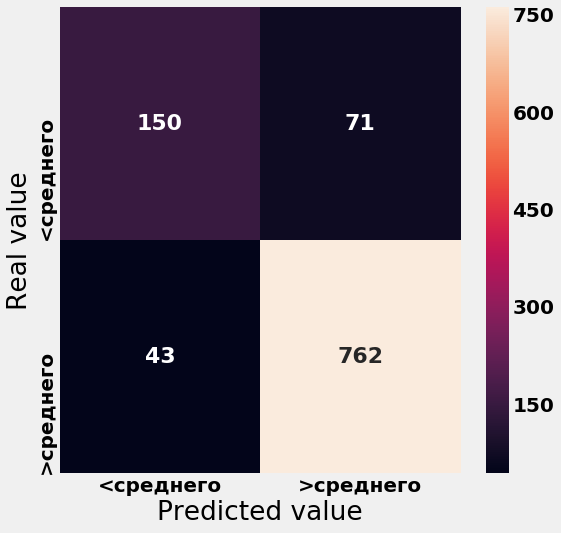

In [0]:
#строим матрицу корреляции для KNN
fig = plt.figure(figsize=(8,8))
nn_mtx = metrics.confusion_matrix(y_test, y_knn)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=['ФОТ < среднего', 'ФОТ > среднего'], 
            yticklabels=['ФОТ < среднего', 'ФОТ > среднего'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")


[[199  22]
 [ 16 789]]


Text(0.5, 13.819999999999972, 'Predicted value')

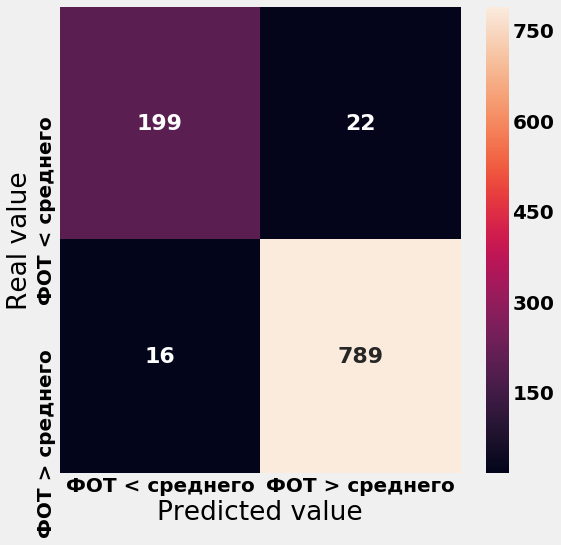

In [0]:
#строим матрицу корреляции для Random forest
fig = plt.figure(figsize=(8,8))
nn_mtx = metrics.confusion_matrix(y_test, y_randomForest)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=['ФОТ < среднего', 'ФОТ > среднего'], 
            yticklabels=['ФОТ < среднего', 'ФОТ > среднего'])
plt.ylabel("Real value")
plt.xlabel("Predicted value")

## Вывожу метрики

In [0]:
print('Accuracy:')
print ('knn =', metrics.accuracy_score(y_test, y_knn), 'randomForest =', metrics.accuracy_score(y_test, y_randomForest))

Accuracy:
knn = 0.8888888888888888 randomForest = 0.9629629629629629


Мы видим что наилудшую точность показал "Случайный лес", так как классы не сбалансированы далее проанализируем Precision, Recall и посчитаем F меру

In [0]:
print('Precision:')
print ('knn =', metrics.precision_score(y_test, y_knn), 'randomForest =', metrics.precision_score(y_test, y_randomForest))

Precision:
knn = 0.9147659063625451 randomForest = 0.9728729963008631


Random Forest лучше чем KNN справился с задачей по классификации

In [0]:
print('Recall:')
print ('knn =', metrics.recall_score(y_test, y_knn), 'randomForest =', metrics.recall_score(y_test, y_randomForest))

Recall:
knn = 0.9465838509316771 randomForest = 0.9801242236024845


Из кода выше видно что и пометрике Recall (метрика обнаружения класса) "Случайный лес" дал лучший результат

In [0]:
report = classification_report(y_test, y_knn, target_names=['ФОТ > среднего', 'ФОТ < среднего'])
print(report)

                precision    recall  f1-score   support

ФОТ > среднего       0.78      0.68      0.72       221
ФОТ < среднего       0.91      0.95      0.93       805

      accuracy                           0.89      1026
     macro avg       0.85      0.81      0.83      1026
  weighted avg       0.89      0.89      0.89      1026



In [0]:
report = classification_report(y_test, y_randomForest, target_names=['ФОТ > среднего', 'ФОТ < среднего'])
print(report)

                precision    recall  f1-score   support

ФОТ > среднего       0.93      0.90      0.91       221
ФОТ < среднего       0.97      0.98      0.98       805

      accuracy                           0.96      1026
     macro avg       0.95      0.94      0.94      1026
  weighted avg       0.96      0.96      0.96      1026



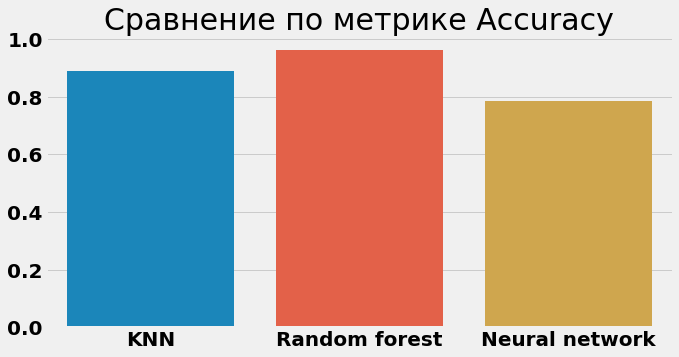

In [0]:
knn_ac=metrics.accuracy_score(y_test, y_knn)
rf_ac=metrics.accuracy_score(y_test, y_randomForest)

fig = plt.figure(figsize=(10, 5))
accuracy = np.array([knn_ac, rf_ac, nn_ac])
ax = sns.barplot(x=["KNN", "Random forest", "Neural network"], y=accuracy)
plt.title("Сравнение по метрике Accuracy", fontsize=30)
plt.show()

# Выводы

Данные анализировались с помощью алгоритма KNN, Random Forest и с помощью полносвязной нейронной сети. 
Лучше всего показал себя Random forest, точность предсказания 96%, по F мере лучший результат так же получен на алгоритме Случайный лес.
Основные признаки, влияющие на целевую переменную:  налоги, среднесписочная численность, страховые взносы

# Получаю данные с предсказаниями



In [0]:
encoded_data, encoders = number_encode_features(data) #кодирую весь первоначальный датасет

In [0]:
encoded_data =encoded_data.drop(['Уставный капитал, RUB', 'Организационно-правовая форма', '2018, Уставный капитал , RUB', '2018, Оплата труда, RUB'], axis=1) #Убираю "лишние" столбцы

In [0]:
encoded_data.dropna(inplace=True) #удаляем пропущенные значения

In [0]:
X = np.array(encoded_data)

In [0]:
y_predict = clf_randomForest.predict(X) #строим предсказания
y_predict

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
encoders

{'Вид деятельности/отрасль': LabelEncoder(),
 'Организационно-правовая форма': LabelEncoder(),
 'Регион регистрации': LabelEncoder()}

In [0]:
encoded_data['Потенциальный клиент'] = y_predict

In [0]:
encoded_data.head() # получаем данные с предсказанием

,"Возраст компании, лет",Регион регистрации,Вид деятельности/отрасль,"2018, Среднесписочная численность работников","2018, Доходы, RUB","2018, Расходы, RUB","2018, Налоги, RUB","2018, Страховые взносы в ПФР, RUB","2018, Выручка, RUB",Потенциальный клиент
0,13.0,49,0,97.0,494224000.0,462466000.0,43388045.0,9005246.0,357464000,1
1,2.5,39,1,13.0,125612000.0,74897000.0,5800614.0,1965044.0,122455000,1
2,14.0,55,6,76.0,364692000.0,361322000.0,38307339.0,10081487.0,345446000,1
3,6.0,55,7,16.0,215452000.0,214183000.0,3566684.0,1494834.0,206558000,1
4,11.0,55,8,15.0,147560000.0,134263000.0,21783067.0,1949765.0,131353000,1
